# Notebook for performing classification of Sorghum varieties for FGVC 9

First load tensorflow and verify installation and ensure devices are operational.

In [1]:
import datetime, os, random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorboard
print(tf.__version__)

2.8.0


In [2]:
devices = tf.config.list_physical_devices('GPU')
for device in devices:
   tf.config.experimental.set_memory_growth(device, True) 
print(devices)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
!nvidia-smi

Mon Apr 18 14:52:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:21:00.0 Off |                    0 |
| N/A   34C    P0    57W / 250W |   1410MiB / 46080MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:81:00.0 Off |                    0 |
| N/A   

In [4]:
TASK = "FashionMNIST"

In [5]:
%load_ext tensorboard


In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
DATA_DICT = {0: "T-shirt/top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

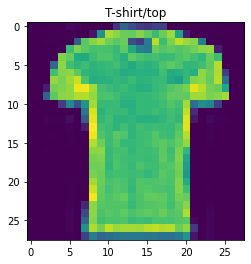

In [8]:
# Show one of the images from the training dataset
img_index = random.sample(range(x_train.shape[0]),1) 
img_label = int(str(*y_train[img_index]))

plt.imshow(np.transpose(x_train[img_index],(1,2,0)))
plt.title(DATA_DICT[img_label])
plt.show()

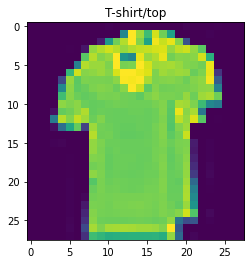

In [9]:
# Show one of the images from the training dataset
img_index = random.sample(range(x_test.shape[0]),1) 
img_label = int(str(*y_test[img_index]))

plt.imshow(np.transpose(x_test[img_index],(1,2,0)))
plt.title(DATA_DICT[img_label])
plt.show()

In [10]:
def create_model():
  model = tf.keras.Sequential()
  # Must define the input shape in the first layer of the neural network
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='relu')),
  model.add(tf.keras.layers.Dropout(0.5)),
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  # Take a look at the model summary
  model.summary()
  return model
  # return tf.keras.models.Sequential([
  #   tf.keras.layers.Flatten(input_shape=(28, 28)),
  #   tf.keras.layers.Dense(512, activation='relu'),
  #   tf.keras.layers.Dropout(0.1),
  #   tf.keras.layers.Dense(10, activation='softmax')
  # ])

In [11]:
logdir = os.path.join("../logs/",''.join([TASK,"-",datetime.datetime.now().strftime("%Y%m%d-%H%M%S")]))

def train_model():

  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=x_train, 
            y=y_train, 
            batch_size=128,
            epochs=100,
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback],
            verbose=1)

trained_model = train_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0

In [12]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_tmp, y_tmp), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

training_len = x_tmp.shape[0]
training_split = 0.8

i = list(range(0,training_len))
random.shuffle(i)

training_inds = set(i[0:int(np.floor(training_split*training_len))])
validation_inds = set()
for i in range(0,training_len):
    if i not in training_inds:
        validation_inds.add(i)



x_train = x_tmp[list(training_inds)]
x_valid = x_tmp[list(validation_inds)]
y_train = y_tmp[list(training_inds)]
y_valid = y_tmp[list(validation_inds)]



print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape, "y_valid shape:", y_valid.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)

x_train shape: (48000, 28, 28) y_train shape: (48000,)
x_valid shape: (12000, 28, 28) y_valid shape: (12000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)
